In [1]:
import numpy as np
import xarray as xr
import pyproj
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean as cmo
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs


import sys
sys.path.append('../')

from plotfunctions import add_lonlat

np.seterr(all='ignore')
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

In [2]:
startyear = 2010
endyear   = 2016

Nax = 5

In [3]:
proj = ccrs.SouthPolarStereo(true_scale_latitude=-75,central_longitude=0)#260-360)
axex = [245.8,251,-75.2,-74.4]
axex2 = [245.7,246.1,-75.11,-74.85]
#axinsex1 = [245.65,246.05,-75.1,-75]
#axinsex2 = [246.15,246.45,-74.73,-74.53]

In [4]:
def makebackground(ax,axex):
    cmap = plt.get_cmap('ocean')
    ds = xr.open_dataset('../../../data/BedMachineAntarctica_2020-07-15_v02.nc')
    ds = ds.isel(x=slice(3400,3800),y=slice(7700,8150))
    mask = xr.where(ds.mask==1,2,ds.mask)
    #mask[:] = xr.where(mask==1,2,mask)
    ds = add_lonlat(ds)
    
    ax.set_facecolor(".7")
    
    cmap1 = mpl.colors.ListedColormap(plt.get_cmap('cmo.ice')(np.linspace(0,.5,255)))
    cmap3 = mpl.colors.ListedColormap(plt.get_cmap('cmo.gray')(np.linspace(.5,.8,255)))

    im1 = ax.pcolormesh(ds.lon,ds.lat,np.where(mask==0,ds.bed,np.nan),cmap=cmap1,shading='nearest',transform=ccrs.PlateCarree(),vmin=-1500,vmax=0)
    im2 = ax.pcolormesh(ds.lon,ds.lat,np.where(mask==2,ds.surface-ds.thickness,np.nan),cmap=cmap3,shading='nearest',transform=ccrs.PlateCarree(),vmin=0,vmax=2000)

    ax.set_extent(axex,crs=ccrs.PlateCarree())
    #gl = ax.gridlines(linewidth=.2,color='.9')
    #gl.xlocator = mpl.ticker.FixedLocator(np.arange(-180,179,1))
    #gl.ylocator = mpl.ticker.FixedLocator(np.arange(-89,89,.2))

In [5]:
def get_gloc():
    x2 = 246.2-360
    y2 = -74.85
    ds = xr.open_dataset(f'../../results/spinup/CrossDots_0.5_mitgcm_1966_1966_001.nc')
    mask = xr.where(ds.lon<x2,ds.tmask,np.nan)
    mask = xr.where(ds.lat<y2,mask,np.nan)
    CS = plt.contour(ds.lon,ds.lat,mask,[.5,1.5])
    vals = CS.collections[0].get_paths()[0].vertices

    glons = vals[:,0]
    glats = vals[:,1]
    return glons,glats

In [6]:
def get_gmelt(glons,glats,lon,lat,melt):
    if len(lon.shape)==1:
        llon,llat = np.meshgrid(lon,lat)
    else:
        llon = lon.copy().values
        llat = lat.copy().values

    melt = np.where(melt==0,np.nan,melt)
    llon = np.where(np.isnan(melt),1e19,llon)
    llat = np.where(np.isnan(melt),1e19,llat)
        
    gmelt = np.zeros(len(glons))
    for g in range(len(glons)):
        dist = np.cos(np.pi*glats[g]/180.)*(np.pi*(glons[g]-llon)/180.)**2+(np.pi*(glats[g]-llat)/180.)**2
        ii = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
        gmelt[g] = melt[ii]
    return gmelt

In [7]:
vmax = 100
vmin = -10
linthresh=1
linscale=.2

fracpos = (np.log10(vmax/linthresh)+linscale)/(np.log10(vmax)+np.log10(-(vmin/linthresh))+2*linscale)
print(fracpos)
nneg = np.int_((1-fracpos)*256)

colors1 = plt.cm.PuBu(np.linspace(.2,.8, nneg))
colors2 = plt.cm.inferno(np.linspace(0, 1, 256-nneg))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)


0.6470588235294118


In [8]:
def plotmelt(nax,lon,lat,melt,title):
    ax = fig.add_subplot(2,Nax,nax,projection=proj)
    makebackground(ax,axex)
    ax.set_extent(axex,crs=ccrs.PlateCarree())
    im = ax.pcolormesh(lon,lat,melt,cmap=mymap,norm=mpl.colors.SymLogNorm(linthresh, vmin=vmin, vmax=vmax, linscale=linscale),shading='nearest',transform=ccrs.PlateCarree())
    #cbar = plt.colorbar(im,ax=ax,orientation='horizontal')
    #cbar.set_ticks([1,10,100])
    #cbar.set_ticklabels([1,10,100])
    ax.set_title(title,loc='left',fontsize=10)
    axins = inset_axes(ax,width="0%",height="0%",loc='lower right',borderpad=0,axes_class=cartopy.mpl.geoaxes.GeoAxes,axes_kwargs=dict(map_projection=proj))    
    axins.set_extent(axex2,crs=ccrs.PlateCarree())
    ax.indicate_inset_zoom(axins, edgecolor="k",lw=1)
    
    ax = fig.add_subplot(2,Nax,nax+Nax,projection=proj)
    makebackground(ax,axex2)
    ax.set_extent(axex2,crs=ccrs.PlateCarree())
    im = ax.pcolormesh(lon,lat,melt,cmap=mymap,norm=mpl.colors.SymLogNorm(linthresh, vmin=vmin, vmax=vmax, linscale=linscale),shading='nearest',transform=ccrs.PlateCarree())
    #cbar = plt.colorbar(im,ax=ax,orientation='horizontal')
    #cbar.set_ticks([1,10,100])
    #cbar.set_ticklabels([1,10,100])
    #ax.set_title(title)
    
    return im
    
    """
    
    glons,glats = get_gloc()
    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    ax.plot(glons,glats,c='darkgreen',lw=1,transform=ccrs.PlateCarree())
    
    ax.scatter(glons[0],glats[0],50,color='darkgreen',transform=ccrs.PlateCarree())
    ax.annotate('A',(glons[0],glats[0]),xytext=(glons[0]-.15,glats[0]+.05),xycoords=transform,color='darkgreen')
    
    ax.scatter(glons[-1],glats[-1],50,color='darkgreen',marker='s',transform=ccrs.PlateCarree())
    ax.annotate('B',(glons[-1],glats[-1]),xytext=(glons[-1]+.0,glats[-1]-.03),xycoords=transform,color='darkgreen')
 
    gmelt = get_gmelt(glons,glats,lon,lat,melt)
    gmelt = np.where(gmelt<1,1,gmelt)
    ax = fig.add_subplot(4,Nax,nax+Nax*3)#projection=proj)
    ax.plot(gmelt,c='darkgreen',lw=1)
    ax.scatter(0,gmelt[0],50,color='darkgreen')
    ax.scatter(len(gmelt),gmelt[-1],50,color='darkgreen',marker='s')
    ax.set_ylim([0,50])
    #ax.set_xticks([0,len(gmelt)])
    ax.set_xticklabels(['A','B'])
    if nax==5:
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        #ax.set_yticks([0,1,2])
        #ax.set_yticklabels(['<1',10,'>100'])
        ax.set_ylabel('Melt rate [m/yr]')
    else:
        ax.set_yticks([])
    
    print(np.nanmean(np.where(melt==0,np.nan,melt)),np.nanmax(np.where(melt==0,np.nan,melt)))
    """
    
    """
    # inset axes....
    axins = inset_axes(ax,width="100%",height="100%",loc='lower right',borderpad=0,axes_class=cartopy.mpl.geoaxes.GeoAxes,axes_kwargs=dict(map_projection=proj))    
    axins.pcolormesh(lon,lat,np.where(melt==0,np.nan,melt),cmap='inferno',norm=mpl.colors.LogNorm(vmin=1,vmax=200),shading='nearest',transform=ccrs.PlateCarree())
    axins.set_extent(axinsex1,crs=ccrs.PlateCarree())
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    ax.indicate_inset_zoom(axins, edgecolor="k",lw=2)
    
    # inset axes....
    axins = inset_axes(ax,width="20%",height="40%",loc='upper left',borderpad=0,axes_class=cartopy.mpl.geoaxes.GeoAxes,axes_kwargs=dict(map_projection=proj))    
    axins.pcolormesh(lon,lat,np.where(melt==0,np.nan,melt),cmap='inferno',norm=mpl.colors.LogNorm(vmin=1,vmax=200),shading='nearest',transform=ccrs.PlateCarree())
    axins.set_extent(axinsex2,crs=ccrs.PlateCarree())
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    ax.indicate_inset_zoom(axins, edgecolor="w",lw=2)
    """

FileNotFoundError: [Errno 2] No such file or directory: b'/nobackup/users/lambert/projects/layer/results/spinup/CrossDots_2.0_mitgcm_2010_2016_030.nc'

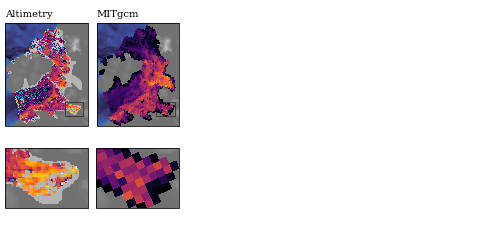

In [9]:
plt.style.use('style_paper')

mpl.rc('figure.subplot',left=.01,right=.9,top=.9,bottom=.0,wspace=.1,hspace=.0)

fig = plt.figure(figsize=(7,3.2))

#Obs
ds = xr.open_dataset('../../../data/gourmelen/CrossonDotson.nc')
ds = add_lonlat(ds)
melt = ds.Band1
im = plotmelt(1,ds.lon,ds.lat,melt,'Altimetry')

#MITgcm
timep= slice(f"{startyear}-1-1",f"{endyear}-12-31")
ds = xr.open_dataset('../../../data/paulholland/melt.nc')
ds = ds.sel(LONGITUDE=slice(360-114.7,360-109),LATITUDE=slice(-75.3,-74.1),TIME=timep)
ds = ds.mean(dim='TIME')
lon   = (ds.LONGITUDE-360.).values
lat   = (ds.LATITUDE-.05).values
melt = ds.melt.values
im = plotmelt(2,lon,lat,np.where(melt==0,np.nan,melt),'MITgcm')

#2km
ds = xr.open_dataset(f'../../results/spinup/CrossDots_2.0_mitgcm_{startyear}_{endyear}_030.nc')
plotmelt(3,ds.lon,ds.lat,np.where(ds.tmask,ds.melt,np.nan),'2.0 km')

#1km
ds = xr.open_dataset(f'../../results/spinup/CrossDots_1.0_mitgcm_{startyear}_{endyear}_030.nc')
plotmelt(4,ds.lon,ds.lat,np.where(ds.tmask,ds.melt,np.nan),'1.0 km')

#500m
ds = xr.open_dataset(f'../../results/spinup/CrossDots_0.5_mitgcm_{startyear}_{endyear}_030.nc')
plotmelt(5,ds.lon,ds.lat,np.where(ds.tmask,ds.melt,np.nan),'0.5 km')

ax = fig.add_subplot(1,Nax,Nax)
ax.set_visible(False)
axins = inset_axes(ax,width="8%",height="90%",loc='lower left',bbox_to_anchor=(1.04, 0.1, 1, 1),bbox_transform=ax.transAxes,borderpad=0)
#formatter = mpl.ticker.LogFormatter(10, labelOnlyBase=False)
ticks = [-10,-3,-1,0,1,3,10,30,vmax]
cbar = plt.colorbar(im, cax=axins,extend='both')
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
#cbar.set_ticks([-10,-1,0,1,10,100])
#cbar.set_ticks([-5,0,10,20,30,40,50])
#cbar.set_ticks([1,10,100])
#cbar.set_ticklabels([1,10,100])
cbar.set_label('Freezing / Melt rate [m/yr]')

plt.savefig('../../figures/draftplot_basalmelt.png',dpi=450)